## CNN trained on a custom dataset for image classification

In this notebook we are going to train an image classifier from scratch in PyTorch.

**Before you proceed with this notebook**, you need to collect the data for the classes you wish to create. To do so, you can follow any of these approaches:

- Download public image datasets from Kaggle, e.g. [animal image dataset](https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/data).

- Install [`gallery-dl`](https://github.com/mikf/gallery-dl). This library allows us to download entire image galleries from sites such as [pinterest](https://www.pinterest.co.uk/), [tumblr](https://www.tumblr.com/), and [bbc](https://www.bbc.co.uk/). Go to [pinterest](https://www.pinterest.co.uk/) and search for a category of your interest. Then, click the filter on the left side and select the option for **Boards**. Select a board and then copy the URL of the pinterest board (e.g. https://www.pinterest.co.uk/user/board-id/) as an argument for the command below. e.g.:

    `gallery-dl https://www.pinterest.co.uk/user-id/board-id/`

    You can run the above command directly in the terminal or through this notebook by adding a `!` before the command.

    Make sure you keep track of the directory where you are when downloading the images.

- Record or source videos of objects, and use `ffmpeg` to extract frames from them. This is a quick way to get many variations of an object. Some quick instructions for `ffmpeg`:

    Download it from [here](https://ffmpeg.org/download.html)
    Then, open the terminal, move into the directory (cd PATH) where you have the video you want to transform into frames, create a folder to save your frames in it and run the command:

    `ffmpeg -i file_name.mov -r 1 -s WxH folder_name/%03d.jpeg`

    This will extract one video frame per second from the video and will output them in files named 001.jpeg, 002.jpeg, etc. Images will be rescaled to fit the new WxH values (you can skipp -s WxH if you do not wish to resize your images). Look [here](https://ffmpeg.org/ffmpeg.html) for more information on `ffmpeg`.

**After you have collected your images** (a folder of images per class), put them into the `data` folder in the current directory, so that you can access them from the path:

`./data/custom-image-dataset/`

Now you can proceed with the notebook. The following code has been adapted from notebook developed by [Terence Broad](https://github.com/terrybroad).

Once you run this code, you can compare it with the code in the notebook `04`. 

First let's do some imports:


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


##### Define our hyperparameters

Now let's define our hyperparameters:

In [6]:
device = 'cpu'
val_size = 0.3
batch_size = 100
momentum = 0.9
learn_rate = 0.001
num_epochs = 10
num_classes = 4 # change if you are working with a different number of classes
data_path = 'data/ml/'

##### Image transformations for the train dataset

Could you augment your training data by adding more transformations to them?

You could randomly change their brightness, contrast, saturation, and hue.

You could flip them horizontally or vertically with a 0.5 probability.

You could randomly rotate them.

Look in [here](https://pytorch.org/vision/stable/transforms.html) and [here](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py) for references and examples. 

In [7]:
train_transform = transforms.Compose(
    [
       transforms.RandomResizedCrop(size=(64, 64), antialias=True),
        transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
   ])

##### Image transformations for the validation dataset

Do you need to also add the above transformations to your validation set? Or are the existing ones enough? You need to consider what the purpose of each dataset is.

In [8]:
val_transform = transforms.Compose(
    [   
        torchvision.transforms.Resize(64, antialias=True),
        torchvision.transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

##### Create our train and test datasets

Here we create our train and validation datasets by splitting the full input dataset into two subsets, with a ratio that was defined with the val_size at the beginning of the notebook. A 70-30 split is quite common.

By setting a `random_state`, we are performing the split randomly but in a deterministic way, i.e. we will always get the same random train_test_split as long as we use the same random_state.

In [9]:
# create train and validation datasets with seperate transforms
train_dataset = ImageFolder(data_path, transform=train_transform)
val_dataset = ImageFolder(data_path, transform=val_transform)

# get length of the full dataset before split, and save it in idx
num_train = len(train_dataset)

# create an array of idx numbers for each element of the full dataset
idx = list(range(num_train))
#print(num_train, idx)

# perform train / val split for data points
train_indices, val_indices = train_test_split(idx, test_size=val_size, random_state=42)

# override datasets to only be samples for each split
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

##### Plot sample images from the two datasets

In the next two cells we are plotting a sample of images from each dataset. See how the data augmentation transforms affect the images of the training set, compared to the images in the validation set.

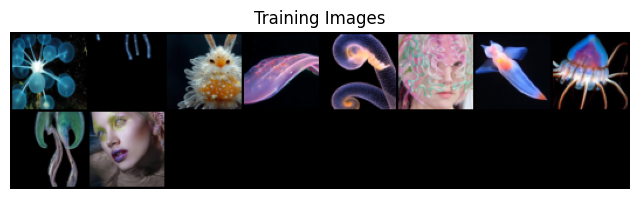

In [10]:
# get a batch of training images
sample_batch = next(iter(train_loader))[0][:64].to(device)

# create a grid of images
img_grid = vutils.make_grid(sample_batch, padding=2, normalize=True)

# convert to NumPy and transpose dimensions for matplotlib
img_grid_np = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

# plot the grid of images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(img_grid_np)
plt.show()

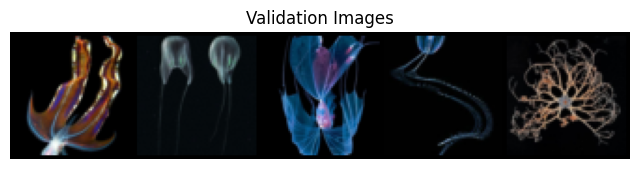

In [11]:
# get a batch of training images
sample_batch = next(iter(val_loader))[0][:64].to(device)

# create a grid of images
img_grid = vutils.make_grid(sample_batch, padding=2, normalize=True)

# convert to NumPy and transpose dimensions for matplotlib
img_grid_np = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

# plot the grid of images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Validation Images")
plt.imshow(img_grid_np)
plt.show()

##### Define our CNN

In [12]:
class ClassificationNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 128, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##### Setup core training objects

Look into available loss functions [here](https://pytorch.org/docs/stable/nn.html#loss-functions).

Look into available optimizers [here](https://pytorch.org/docs/stable/optim.html).

In [13]:
model = ClassificationNetwork()
model.to(device)

# selecting cross entropy as the loss function for our classification
criterion = nn.CrossEntropyLoss()

# selecting stochastic gradient descent as our optimization algorithm
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

# print model architecture
model.eval()

ClassificationNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

##### Training

What is different here from the training we did for the MNIST CNN classifier? 

In [14]:
train_losses = []
val_losses = []

for epoch in range(num_epochs): 
    train_loss = 0.0
    
    # training loop
    for batch_idx, (data, target) in enumerate(train_loader):
        # get data
        inputs = data.to(device)
        labels = target.to(device)
        
        # zero the gradients
        optimizer.zero_grad()
        # forward pass
        predictions = model(inputs)
        # compute the loss
        loss = criterion(predictions, labels)
        # backpropagate
        loss.backward()
        # update the parameters, i.e. weights
        optimizer.step()

        # save statistics to plot later
        train_loss += loss.item()
    
    # validation loop
    with torch.no_grad():
        val_loss = 0.0
        for batch_idx, (data, target) in enumerate(val_loader):
            # get data
            inputs = data.to(device)
            labels = target.to(device)
            # forward pass, no backpropagation and optimisation
            predictions = model(inputs)
            # compute the loss
            loss = criterion(predictions, labels)
            # save statistics to plot later
            val_loss += loss.item()
    
    # normalise cumulative losses to dataset size
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    
    # added cumulative losses to lists to plot later
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}')

Epoch 1, train loss: 1.388, val loss: 1.388
Epoch 2, train loss: 1.387, val loss: 1.387
Epoch 3, train loss: 1.386, val loss: 1.385
Epoch 4, train loss: 1.387, val loss: 1.383
Epoch 5, train loss: 1.386, val loss: 1.381
Epoch 6, train loss: 1.386, val loss: 1.378
Epoch 7, train loss: 1.384, val loss: 1.374
Epoch 8, train loss: 1.378, val loss: 1.371
Epoch 9, train loss: 1.380, val loss: 1.368
Epoch 10, train loss: 1.374, val loss: 1.364


##### Plot training vs validation loss 

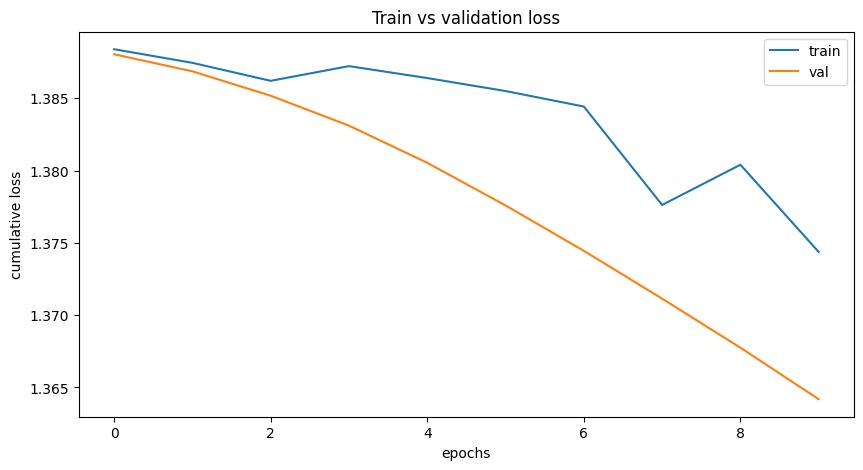

In [15]:
plt.figure(figsize=(10,5))
plt.title("Train vs validation loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()

##### Save the model

In [25]:
torch.save(model.state_dict(), './models/img_classfier_model.pt')

### Tasks to do in-class and further explore at home

**Task 1:** Create your own dataset with 2, 3, or more classes, based on one of the suggested approaches. It would be effective to have at least 1000 images/class. Create a folder for each one of your classes and save the respective images there. Then move all of the class folders in `./data/custom-image-dataset`. Make sure you manually clean-up your data before training, to remove any irrelevant or destroyed images.

**Task 2:** Run all the cells in this code to train a classifier on your custom dataset.

**Task 3:** Add image transformations on the training dataset. Look in [here](https://pytorch.org/vision/stable/transforms.html) and [here](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py) for references and examples. 

**Task 4:** Create a new notebook where you call the model that you just saved from this training and test it on some new unseen data. Look into the MNIST notebooks 01 and 02, as well as the PyTorch website, to figure out how you can call and use an already trained model.

**Bonus Challenges:**

**Bonus 1:** Look into the concept of Early Stopping. What is it? Could it be useful for our training? How? Attempt to implement it by adding the following lines of code after the training loop is completed:

   `if val_loss < best_loss:`
        
        `best_loss = val_loss`
        
        `torch.save(model.state_dict(), 'best_model_from_scratch.pt')`

For this to work, you will have to initialise best_loss with a high value before you enter the training loop.

**Bonus 2:** In this example you are building your classifier from scratch, i.e. you decide yourself what the architecture of the network is and you train it from the very beginning. Could you explore a way for training your classifier based on a pre-trained model? There are many available pre-trained models in [the torchvision models library](https://pytorch.org/vision/stable/models.html), like [ResNet](https://arxiv.org/abs/1512.03385) which is trained on [imagenet dataset](https://www.image-net.org/). This approach will require a few changes and additions in your notebook. Attempt it if you are feeling adventurous!